In [21]:
import os
import shutil
import numpy as np
import pandas as pd
import math

In [22]:
META_DIR = 'D:/Downloads/DL#+Beginner/DL# Beginner/meta-data/meta-data/train.csv'
DATA_DIR = 'D:/Downloads/train_odl/train'

In [23]:

# Load the data into a DataFrame
train_metadata = pd.read_csv(META_DIR)

# Print the size of the training set
print("Training set size:", train_metadata.shape)

# Display the first 5 rows of the DataFrame
train_metadata.head(5)


Training set size: (13000, 2)


Image_id           Animal
0  Img-1.jpg     hippopotamus
1  Img-2.jpg         squirrel
2  Img-3.jpg     grizzly+bear
3  Img-4.jpg               ox
4  Img-5.jpg  german+shepherd

In [24]:
samples_by_class = train_metadata.groupby('Animal').count().reset_index()
samples_by_class

Animal  Image_id
0          antelope       695
1               bat       256
2            beaver       133
3            bobcat       418
4           buffalo       606
5         chihuahua       386
6        chimpanzee       477
7            collie       680
8         dalmatian       359
9   german+shepherd       687
10     grizzly+bear       583
11     hippopotamus       464
12            horse      1111
13     killer+whale       193
14             mole        60
15            moose       476
16            mouse       124
17            otter       519
18               ox       501
19      persian+cat       491
20          raccoon       346
21              rat       220
22       rhinoceros       477
23             seal       665
24      siamese+cat       341
25    spider+monkey       189
26         squirrel       808
27           walrus       148
28           weasel       184
29             wolf       403

In [25]:
# Preprocessing Data
from tensorflow.keras.layers import (
    Resizing, Rescaling, RandomFlip,
    RandomRotation, RandomZoom
)
import tensorflow as tf
import cv2
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomFlip

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
normalization_layer = Rescaling(1./255)
resizing_layer = Resizing(IMAGE_HEIGHT, IMAGE_WIDTH)
rotation_layer = RandomRotation(0.0833)
random_flip_layer = RandomFlip("horizontal_and_vertical")


def resize_image(x):
    return resizing_layer(x)

def rotate_image(x):
    return rotation_layer(x)

def rescale_image(x):
    return normalization_layer(x)


def flip_image(x):
    return random_flip_layer(x)

# def grayscale_image(x):
#     return cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) 

def gaussian_blur(x):
    return cv2.GaussianBlur(x, (3, 3), 0)

def canny_edge(x):
    return cv2.Canny(x, 100, 255)

def dilate_image(x):
    return cv2.dilate(x, np.ones((1, 1), np.uint8), iterations=1)

# def threshold_image(x):
#     _, x = cv2.threshold(x, 130, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     return x 

def equalization_contrast_color(img):
    # Convert the image from BGR to HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Equalize the histogram of the V (Value) channel
    hsv_img[:, :, 2] = cv2.equalizeHist(hsv_img[:, :, 2])
    
    # Convert back to BGR color space
    equalized_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)
    
    return equalized_img

def adjust_brightness_constrast(x):
    return cv2.addWeighted(x, 2.0, np.zeros(x.shape, x.dtype), 0, 0)

def sharpening_image(x):
    return cv2.Laplacian(x, cv2.CV_64F)


def preprocess_image(x):
    x = resize_image(x)
    x = rescale_image(x)
    # x = rotate_image(x)
    # x = flip_image(x)
    x = x.numpy()
    # x = grayscale_image(x)

    # Ensure image is uint8 type before applying cv2 functions
    if x.dtype != np.uint8:
        x = (x * 255).astype('uint8')
    
    # cv2 preprocessing
    # x = adjust_brightness_constrast(x)
    # x = equalization_contrast_color(x) 
    # x = gaussian_blur(x)
    # x = sharpening_image(x.astype(float))   
    #x = threshold_image(x.astype('uint8'))

    return x


In [26]:
# This should point to where your original images are before preprocessing
DATA_DIR = 'D:/Downloads/train_odl/train' 

for index, row in train_metadata.iterrows():
    image_path = row['Image_id']
    image_class = row['Animal']
    class_path = f'data/preprocessed_data/{image_class}'

    if not os.path.exists(class_path):
        os.makedirs(class_path)

    input_path = f'{DATA_DIR}/{image_path}'
    output_path = f'{class_path}/{image_path}'

    print(f"Trying to load image from: {input_path}")  # Check what path is being used
    img = cv2.imread(input_path)
    if img is None:
        print(f"Failed to load image from {input_path}")
        continue

    img = preprocess_image(img)
    cv2.imwrite(output_path, img)
    print(f"Saved preprocessed image to {output_path}")


Trying to load image from: D:/Downloads/train_odl/train/Img-1.jpg
Saved preprocessed image to data/preprocessed_data/hippopotamus/Img-1.jpg
Trying to load image from: D:/Downloads/train_odl/train/Img-2.jpg
Saved preprocessed image to data/preprocessed_data/squirrel/Img-2.jpg
Trying to load image from: D:/Downloads/train_odl/train/Img-3.jpg
Saved preprocessed image to data/preprocessed_data/grizzly+bear/Img-3.jpg
Trying to load image from: D:/Downloads/train_odl/train/Img-4.jpg
Saved preprocessed image to data/preprocessed_data/ox/Img-4.jpg
Trying to load image from: D:/Downloads/train_odl/train/Img-5.jpg
Saved preprocessed image to data/preprocessed_data/german+shepherd/Img-5.jpg
Trying to load image from: D:/Downloads/train_odl/train/Img-6.jpg
Saved preprocessed image to data/preprocessed_data/buffalo/Img-6.jpg
Trying to load image from: D:/Downloads/train_odl/train/Img-7.jpg
Saved preprocessed image to data/preprocessed_data/otter/Img-7.jpg
Trying to load image from: D:/Downloads/tra

### Importing data as Generator in TensorFlow

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL

In [28]:
import tensorflow as tf

BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
VALIDATION_SPLIT = 0.2

# Define the directory where the preprocessed data is stored
DATA_DIR = 'data/preprocessed_data'

# Set up training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'  # Ensure labels are one-hot encoded if necessary
)

# Retrieve class names before applying transformations
class_names = train_ds.class_names
print("Class names:", class_names)

# Configure the dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Set up validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'  # Ensure labels are one-hot encoded if necessary
)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 13000 files belonging to 30 classes.
Using 10400 files for training.
Class names: ['antelope', 'bat', 'beaver', 'bobcat', 'buffalo', 'chihuahua', 'chimpanzee', 'collie', 'dalmatian', 'german+shepherd', 'grizzly+bear', 'hippopotamus', 'horse', 'killer+whale', 'mole', 'moose', 'mouse', 'otter', 'ox', 'persian+cat', 'raccoon', 'rat', 'rhinoceros', 'seal', 'siamese+cat', 'spider+monkey', 'squirrel', 'walrus', 'weasel', 'wolf']
Found 13000 files belonging to 30 classes.
Using 2600 files for validation.


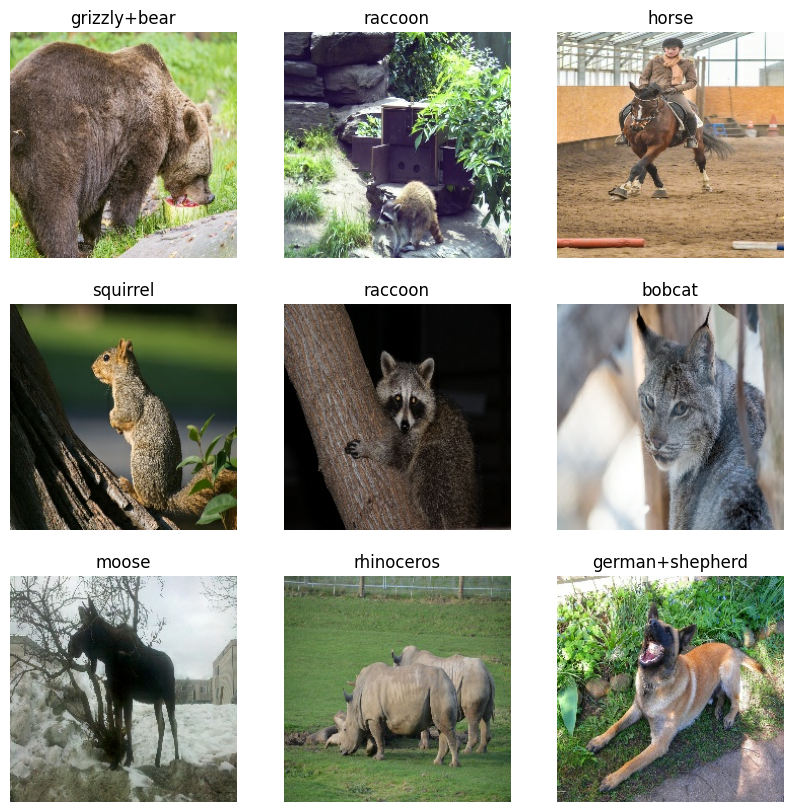

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    labels = labels.numpy()  # Convert tensor to numpy array for easier indexing
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Check if labels are one-hot encoded and convert to integer index if necessary
        if len(labels[i].shape) > 0 and labels[i].size > 1:  # More than one element suggests one-hot encoding
            label_index = int(np.argmax(labels[i]))  # Get the index of the max value for one-hot encoded labels
        else:
            label_index = int(labels[i])  # Directly use label as index if it's already scalar
        
        plt.title(class_names[label_index])
        plt.axis("off")
plt.show()


In [30]:
# optimize performance of the dataset
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # assign buffer size of 1000 for random picking
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

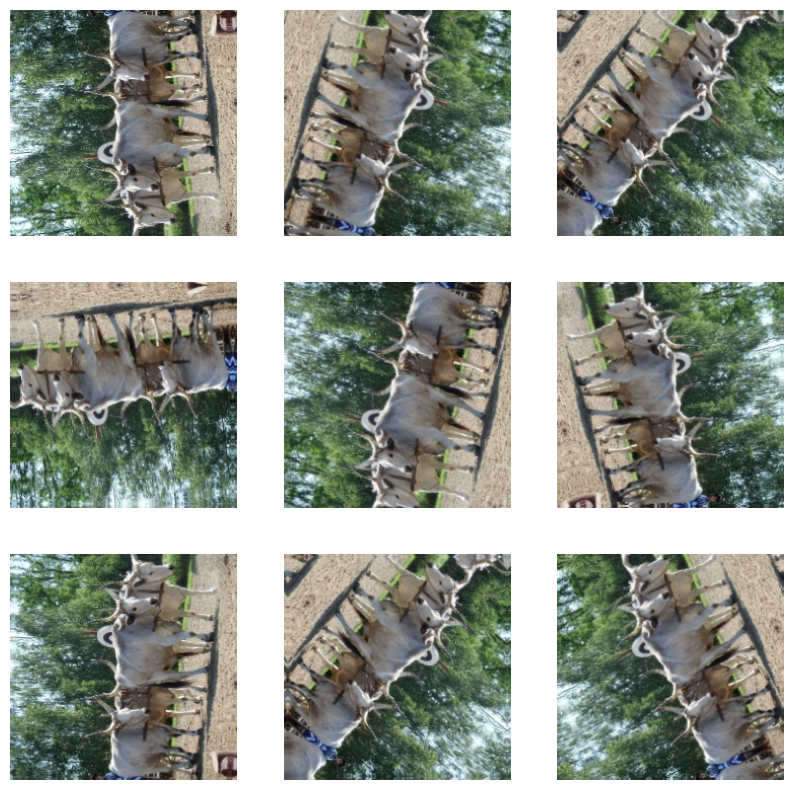

In [31]:
from tensorflow.keras.layers import (
    RandomFlip, RandomRotation, RandomZoom
)

# data augmentation
data_augmentation = tf.keras.models.Sequential(
  [
    RandomFlip("horizontal_and_vertical",
                      input_shape=(IMAGE_HEIGHT,
                                  IMAGE_WIDTH,
                                  3),
                              seed=42),
    RandomRotation(0.3),
    RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [32]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load the base EfficientNetB0 model with pre-trained ImageNet weights
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the convolutional base to prevent its weights from being updated during training
base_model.trainable = False

# Create the model architecture by adding new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout added for regularization
predictions = Dense(30, activation='softmax')(x)  # Adjust the Dense layer according to your class count

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_8 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  7          ['rescaling_8[0][0]']            
 )                                                                                                
                                                                                            

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(30, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00001)

# Train the model with callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,  # Increased epochs considering early stopping
    callbacks=[early_stopping, reduce_lr]
)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 26, 26, 128)     

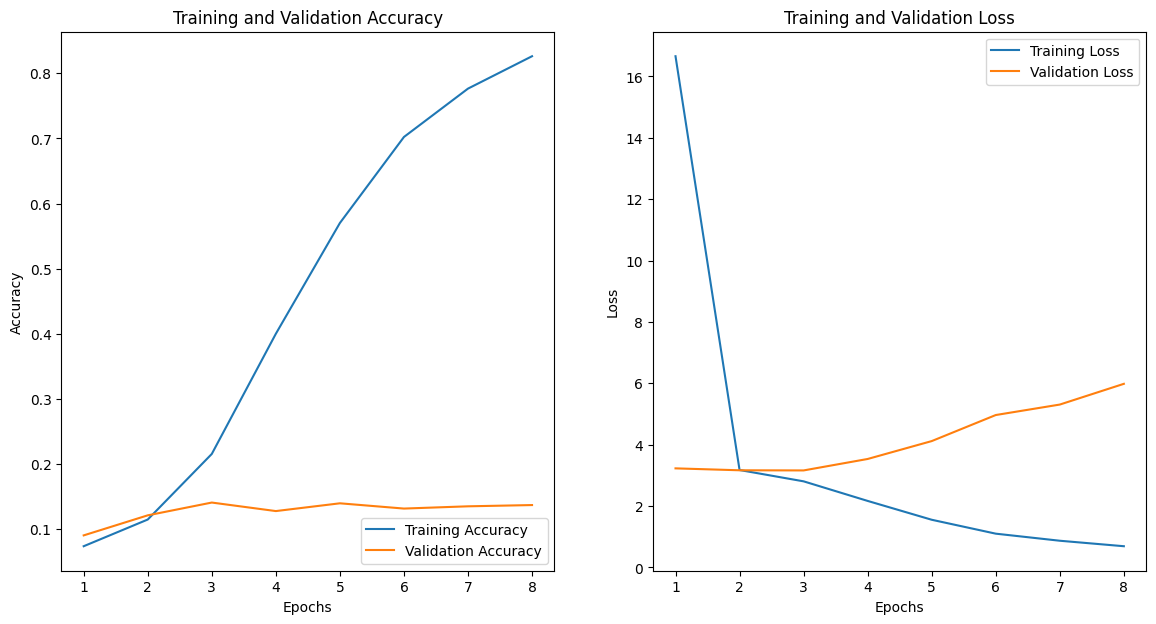

In [18]:
import matplotlib.pyplot as plt

# Replace 'history' with the variable containing your model's history if it has a different name
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()
